# Learning Algorithms

```{contents}
```

## Where the data at

In [2]:
import pandas as pd
import sys
sys.path.append('../')
# from source.pacmap_functions import *

mount = '/mnt/d/'
input_path = mount + 'MethylScore/Intermediate_Files/'
output_path = mount + 'MethylScore/Processed_Data/'

## Load data

In [3]:
# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'3308samples_333059cpgs_withbatchcorrection_bvalues.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'201samples_357839cpgs_withbatchcorrection_bvalues.pkl').sort_index()

# use overlapping features between df_discovery and df_validation
common_features = [x for x in df_discovery.columns if x in df_validation.columns]

# apply `common_features` to both df_discovery and df_validation
# df_discovery = df_discovery[common_features]
# df_validation = df_validation[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Discovery dataset (df_discovery) contains 333059 columns (5mC nucleotides/probes) and 3308 rows (samples).
 Validation dataset (df_validation) contains 357839 columns (5mC nucleotides/probes) and 201 rows (samples).


In [4]:
# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

# Load clinical data
validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Adjust clinical data
discovery_clinical_data['Train-Test'] = 'Train Samples'
validation_clinical_data['Train-Test'] = 'Test Samples'

discovery_clinical_data['PaCMAP Output'] = 'Patient Samples'
validation_clinical_data['PaCMAP Output'] = 'Patient Samples'

discovery_clinical_data['Batch'] = df_discovery['Batch']
validation_clinical_data['Batch'] = 'St Jude Children\'s'


In [6]:
discovery_clinical_data.shape

(3308, 2285)

In [5]:
discovery_clinical_data[['Clinical Trial', ]].value_counts(dropna=False)

Clinical Trial          
NOPHO ALL92-2000            933
AAML0531                    628
AAML1031                    581
Beat AML Consortium         316
TCGA AML                    194
CETLAM SMD-09 (MDS-tAML)    166
French GRAALL 2003–2005     141
TARGET ALL                  131
AAML03P1                     72
Japanese AML05               64
CCG2961                      41
NaN                          41
Name: count, dtype: int64

## Reduce dimensionality with PaCMAP

In [6]:
import pacmap
print('PaCMAP version:', pacmap.__version__)

components_list = [2, 5]
for components in components_list:

    # Initialize the instance
    reducer = pacmap.PaCMAP(n_components=components, n_neighbors=15, MN_ratio=0.4, FP_ratio=16.0, 
                            random_state=42, lr=0.1, num_iters=5000, save_tree=True)

    # Project the high dimensional dataset into a low-dimensional embedding
    embedding_training = reducer.fit(df_discovery.to_numpy(dtype='float16'))

    # Save reducer
    pacmap.save(reducer, f'../models/pacmap_{components}d_model_al_atlas')

# Load reducer
reducer = pacmap.load('../models/pacmap_5d_model_al_atlas')

# Project the high dimensional dataset into existing embedding space and return the embedding.
embedding_training = reducer.transform(df_discovery.to_numpy(dtype='float16'))
embedding_validation = reducer.transform(df_validation.to_numpy(dtype='float16'))


PaCMAP version: 0.7.0


/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


The PaCMAP instance is successfully saved at ../models/pacmap_2d_model_al_atlas.pkl, and the Annoy Index is saved at ../models/pacmap_2d_model_al_atlas.ann.
To load the instance again, please do `pacmap.load(../models/pacmap_2d_model_al_atlas)`.


/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


The PaCMAP instance is successfully saved at ../models/pacmap_5d_model_al_atlas.pkl, and the Annoy Index is saved at ../models/pacmap_5d_model_al_atlas.ann.
To load the instance again, please do `pacmap.load(../models/pacmap_5d_model_al_atlas)`.


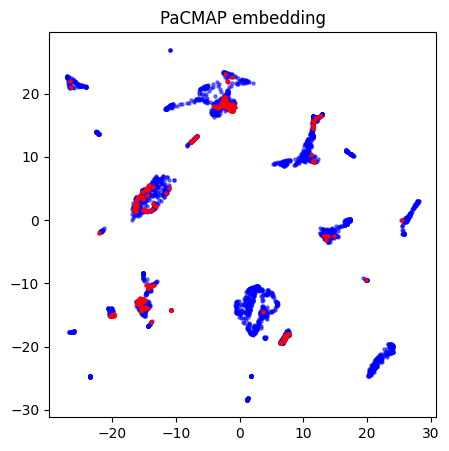

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(embedding_training[:, 3], embedding_training[:, 2], c='blue', s=5, alpha=0.5)
plt.scatter(embedding_validation[:, 3], embedding_validation[:, 2], c='red', s=5, alpha=1)
plt.title('PaCMAP embedding')
plt.show()

## Preprocess data for classifiers

### Load output from PaCMAP

Reloading it here to allow for running the cells below without running the PaCMAP code above.

In [ ]:
import pandas as pd
import numpy as np

input_path = '/mnt/d/MethylScore/Intermediate_Files/'
output_path = '/mnt/d/MethylScore/Processed_Data/'

n_components = 5

# Create a list of strings containing "PaCMAP " + the number of components
components = [f'PaCMAP {i}' for i in range(1, n_components+1)]

# Load pacmap output data
df = pd.read_csv(output_path+f'pacmap_output/pacmap_{n_components}d_model_dx_al.csv', index_col=0)

### Select samples Px

In [ ]:

# Drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_px = df[~df['Vital Status'].isna()]

df_px2 = df_px.copy()

# # Exclude the `Blood Derived Normal`and `Bone Marrow Normal` from `Sample Type`
# df_px2 = df_px[~df_px['Sample Type'].isin(['Relapse', 'Recurrent Blood Derived Cancer - Bone Marrow',
#                                             'Recurrent Blood Derived Cancer - Peripheral Blood',
#                                             'Blood Derived Normal', 'Bone Marrow Normal'])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_px2.shape[0], 'samples removed.'\
, df_px2.shape[0], 'samples remaining.')

### Select samples Dx

In [ ]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_dx = df[~df['WHO 2022 Diagnosis'].isna()]

# exclude the classes with fewer than 10 samples
df_dx2 = df_dx[~df_dx['WHO 2022 Diagnosis'].isin([
                                    'AML with t(1;22); RBM15::MKL1',
                                       'MPAL with t(v;11q23.3)/KMT2A-r',
                                       'B-ALL with hypodiploidy',
                                       'AML with t(16;21); FUS::ERG',
                                       'AML with t(9;22); BCR::ABL1'
                                       ])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_dx2.shape[0], 'samples removed.'\
, df_dx2.shape[0], 'samples remaining.')

### Define X and y

In [ ]:
def custom_train_test_split(df, feature_columns, target_column, split_column):

    X = df[feature_columns].to_numpy()
    y = df[target_column].to_numpy()

    train_mask = df[split_column] == 'Train Samples'
    test_mask = df[split_column] == 'Test Samples'

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

    return X_train, X_test, y_train, y_test

# Execution
X_train_dx, X_test_dx, y_train_dx, y_test_dx = custom_train_test_split(df_dx2, components,'WHO 2022 Diagnosis', 'Train-Test')
X_train_px, X_test_px, y_train_px, y_test_px = custom_train_test_split(df_px2, components,'Vital Status', 'Train-Test')


## Benchmark classifiers

### Define confusion matrix plot function

In [ ]:
def plot_confusion_matrix_stacked(clf, x_train, y_train, x_test, y_test, 
                                  title='', 
                                  tick_fontsize=10, label_fontsize=10,
                                  figsize=(10, 5)):

    sns.set_theme(style='white')

    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)

    fig.subplots_adjust(wspace=0.05)  # Adjust the width space

    for i, (ax, x, y, subset) in enumerate(zip(axs, [x_train, x_test], [y_train, y_test],
                                                ['Train with 10-fold CV', 'Validation'])):
        predictions = clf.predict(x)
        print(f'Overall accuracy score in {subset}: {accuracy_score(y, predictions):.3f}')
        cm = confusion_matrix(y, predictions, labels=clf.classes_, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', colorbar=False, ax=ax)
    

        # Set font size of the numbers inside the confusion matrix
        for texts in disp.text_:
            for text in texts:
                text.set_fontsize(label_fontsize)

        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_title(subset + ', n=' + str(len(x)), fontsize=label_fontsize+1, pad=10)
        ax.set_xlabel('Predicted label', fontsize=label_fontsize+1)

        # Add y labels
        if i == 0:
            ax.set_ylabel('True label', fontsize=label_fontsize+1)
        else:
            ax.set_ylabel('')

        # remove x tick labels
        ax.xaxis.set_ticklabels([])
        
    plt.show()

### Execute 

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


def benchmark_classifier(X_train, y_train, X_test, y_test, figsize=(16,8)):

    param_grid = {
    'num_leaves': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], # number of leaves in full tree
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # maximum depth of a tree
    # 'learning_rate': [0.001, 0.01, 0.015, 0.02, 0.1],  # learning rate
    # 'n_estimators': [10, 50, 100, 200],  # number of trees (or rounds)
    }

    # Initialize the LGBM Classifier with regularization
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1, reg_alpha=1.0, reg_lambda=1.0)

    # Perform grid search with stratified cross-validation
    grid_search = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")

    # Get the best model
    clf = grid_search.best_estimator_

    plot = plot_confusion_matrix_stacked(clf, X_train, y_train, X_test, y_test,
                                  tick_fontsize=7, label_fontsize=7, figsize=figsize)
    return clf, plot

    # Plot the confusion matrix

# Benchmark, train
lgbm_dx_model, plot = benchmark_classifier(X_train_dx, y_train_dx, X_test_dx, y_test_dx)
lgbm_px_model, plot = benchmark_classifier(X_train_px, y_train_px, X_test_px, y_test_px, figsize=(5,3))

# Save models
joblib.dump(lgbm_px_model,'../models/lgbm_px_model.pkl')
joblib.dump(lgbm_dx_model,'../models/lgbm_dx_model.pkl')


## Save results

In [ ]:
def save_predictions(df, classifier, model_name):

    # ignore sklearn warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Select necessary columns and set the index
    df_features = df.set_index('index')[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']]

    # Predict using the selected columns
    predictions = classifier.predict(df_features)

    # Predict probabilities using the selected columns
    probabilities = classifier.predict_proba(df_features)

    # Convert predictions to a Series with the same index as df_features
    predictions_series = pd.Series(predictions, index=df_features.index, name=model_name)

    # Convert probabilities to a DataFrame with the same index as df_features and the same columns as the classes
    probabilities_df = pd.DataFrame(probabilities, index=df_features.index, columns=classifier.classes_).round(3)

    # Add " - predict_proba" to the column names
    probabilities_df.columns ='P(' + probabilities_df.columns + ')'

    # # Create a new column named "Confidence" and set it to True if the max probability is >= confidence_threshold
    # probabilities_df['Confidence >=' + str(confidence_threshold)] = probabilities_df.max(axis=1) >= confidence_threshold

    # Transform classes of the predictions into integers based on unique values in the classes
    probabilities_df[model_name + '_int'] = predictions_series.map({c: i for i, c in enumerate(classifier.classes_)})

    # Join predictions with the original DataFrame (already indexed)
    df_joined = predictions_series.to_frame().join(probabilities_df)

    return df_joined

# Execution
df_pred_px = save_predictions(df=df, classifier=lgbm_px_model, model_name='AML Epigenomic Risk')
df_pred_dx = save_predictions(df=df, classifier=lgbm_dx_model, model_name='AL Epigenomic Phenotype')

In [ ]:
df_combined = df.join(df_pred_px).join(df_pred_dx)

## Other benchmarked classifiers

### Gaussian Process Classifier

In [ ]:
# from sklearn.gaussian_process import GaussianProcessClassifier

# # Define the parameter grid
# param_grid = {
#     'multi_class': ['one_vs_rest'], 
# }

# # Initialize the Gaussian Process Classifier
# gpc = GaussianProcessClassifier(random_state=42, n_jobs=-1)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(gpc, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
# grid_search.fit(X_train, y_train)

# # Fit and predict using the best estimator
# gpc_px_model = grid_search.best_estimator_

# y_pred = gpc_px_model.predict(X_test)  # Predict using the best model

# # Print the best parameters and the best score
# print(f"Best parameters: {grid_search.best_params_}")

# # Fit and predict using the best estimator
# gpc_px_model = grid_search.best_estimator_

# y_pred_train = gpc_px_model.predict(X_train)  # Predict using the best model
# y_pred_test = gpc_px_model.predict(X_test)  # Predict using the best model


# print(f'Overall accuracy score with best estimator in train: {accuracy_score(y_train, y_pred_train):.3f}')
# print(f'Overall accuracy score with best estimator in test: {accuracy_score(y_test, y_pred_test):.3f}')

# # plot the confusion matrix
# plot_confusion_matrix_stacked(gpc_px_model, X_train, y_train, X_test, y_test,
#                               tick_fontsize=7, label_fontsize=7, figsize = (5,3))

# # you shall save the model
# pickle.dump(gpc_px_model, open('../models/gpc_px_model.pkl', 'wb'))


## Watermark

In [ ]:
%load_ext watermark

In [ ]:
# watermark with all libraries used in this notebook
%watermark -v -p numpy,pandas,bokeh,pacmap,itables -a Francisco_Marchi@Lamba_Lab_UF -d -m